In [125]:
!pip install pytorch_model_summary

In [126]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from pytorch_model_summary import summary

In [127]:
PI = torch.from_numpy(np.asarray(np.pi))
EPS = 1.0e-5


def log_categorical(x, p, num_classes=256, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes=num_classes)
    log_p = x_one_hot * torch.log(torch.clamp(p, EPS, 1.0 - EPS))
    if reduction == "avg":
        return torch.mean(log_p, dim)
    elif reduction == "sum":
        return torch.sum(log_p, dim)
    else:
        return log_p


def log_bernoulli(x, p, reduction=None, dim=None):
    pp = torch.clamp(p, EPS, 1.0 - EPS)
    log_p = x * torch.log(pp) + (1.0 - x) * torch.log(1.0 - pp)
    if reduction == "avg":
        return torch.mean(log_p, dim)
    elif reduction == "sum":
        return torch.sum(log_p, dim)
    else:
        return log_p


def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
    D = x.shape[1]
    log_p = (
        -0.5 * D * torch.log(2.0 * PI)
        - 0.5 * log_var
        - 0.5 * torch.exp(-log_var) * (x - mu) ** 2.0
    )
    if reduction == "avg":
        return torch.mean(log_p, dim)
    elif reduction == "sum":
        return torch.sum(log_p, dim)
    else:
        return log_p


def log_standard_normal(x, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2.0 * PI) - 0.5 * x**2.0
    if reduction == "avg":
        return torch.mean(log_p, dim)
    elif reduction == "sum":
        return torch.sum(log_p, dim)
    else:
        return log_p

In [128]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

In [129]:
class Encoder(nn.Module):
    def __init__(self, encoder_net):
        super().__init__()
        self.encoder = encoder_net

    @staticmethod
    def reparameterizing(mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)

        return mu + std * eps

    def encode(self, x):
        h_e = self.encoder(x)

        mu_e, log_var_e = torch.chunk(h_e, 2, dim=1)
        return mu_e, log_var_e

    def sample(self, x=None, mu_e=None, log_var_e=None):
        if (mu_e is None) and (log_var_e is None):
            mu_e, log_var_e = self.encode(x)
        return self.reparameterizing(mu_e, log_var_e)

    def log_prob(self, x=None, mu_e=None, log_var_e=None, z=None):
        # Reuse provided encoder stats when available to avoid re-encoding None
        if (mu_e is None) or (log_var_e is None):
            mu_e, log_var_e = self.encode(x)

        if z is None:
            z = self.sample(x, mu_e, log_var_e)

        return log_normal_diag(z, mu_e, log_var_e)

    def forward(self, x, type='log_prob'):
        assert type in ['encode', 'log_prob'], 'Type could be either encode or log_prob'

        if type == 'log_prob':
            return self.log_prob(x)
        else:
            return self.sample(x)

In [130]:
class Decoder(nn.Module):

    def __init__(self, decoder_net, distribution, num_vals):
        super().__init__()
        self.decoder = decoder_net
        self.distribution = distribution
        self.num_vals = num_vals

    def decode(self, z):
        h_d = self.decoder(z)
        if self.distribution == 'categorical':
            b = h_d.shape[0] # Batch size
            d = h_d.shape[1] // self.num_vals # Dimensionality of x

            h_d = h_d.view(b, d, self.num_vals)
            mu_d = torch.softmax(h_d, 2)
            return [mu_d]

        elif self.distribution == 'bernoulli':
            mu_d = torch.sigmoid(h_d)
            return [mu_d]

        else:
            raise ValueError('Only: categorical or bernulli')

    def sample(self, z):
        outs = self.decode(z)

        if self.distribution == "categorical":
            mu_d = outs[0]
            b = mu_d.shape[0]  # Batch size
            m = mu_d.shape[1]  # Dimensionality of x

            mu_d = mu_d.view(mu_d.shape[0], -1, self.num_vals)
            p = mu_d.view(-1, self.num_vals)

            x_new = torch.multinomial(p, num_samples=1).view(b, m)

        elif self.distribution == "bernoulli":
            mu_d = outs[0]
            x_new = torch.bernoulli(mu_d)

        return x_new

    def log_prob(self, x, z):
        outs = self.decode(z)

        if self.distribution == "categorical":
            mu_d = outs[0]
            log_p = log_categorical(x, mu_d, num_classes=self.num_vals, reduction='sum', dim=-1).sum(-1)
        elif self.distribution == "bernoulli":
            mu_d = outs[0]
            log_p = log_bernoulli(x, mu_d, reduction="sum", dim=-1).sum(-1)
        return log_p
    
    def forward(self, z, x=None, type='log_prob'):
        assert type in ['decoder', 'log_prob'], 'Type could be either decode or log_prob'
        
        if type == 'log_prob':
            return self.log_prob(x, z)
        else:
            return self.sample(z)

In [131]:
class Prior(nn.Module):
    def __init__(self, L):
        super(Prior, self).__init__()
        self.L = L

    def sample(self, batch_size):
        z = torch.randn((batch_size, self.L))
        return z

    def log_prob(self, z):
        return log_standard_normal(z)

In [132]:
class VAE(nn.Module):

    def __init__(
        self,
        encoder_net,
        decoder_net,
        num_vals=256,
        L=16,
        likelihood_type="categorical",
    ):
        super().__init__()
        
        self.encoder = Encoder(encoder_net=encoder_net)
        self.decoder = Decoder(distribution=likelihood_type, decoder_net=decoder_net, num_vals=num_vals)
        self.prior = Prior(L=L)
        
        self.num_vals = num_vals
        self.likelihood_tupe = likelihood_type
        
    def forward(self, x, reduction='avg'):
        mu_e, log_var_e = self.encoder.encode(x)
        z = self.encoder.sample(mu_e=mu_e, log_var_e=log_var_e)
        
        RE = self.decoder.log_prob(x, z)
        KL = (self.prior.log_prob(z) - self.encoder.log_prob(mu_e=mu_e, log_var_e=log_var_e, z=z)).sum(-1)
        
        if reduction == 'sum':
            return -(RE + KL).sum()
        else:
            return -(RE + KL).mean()
        
    def sample(self, batch_size=64):
        z = self.prior.sample(batch_size=batch_size)
        return self.decoder.sample(z)
            

In [133]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + ".model", weights_only=False)

    model_best.eval()
    loss = 0.0
    N = 0.0
    for indx_batch, test_batch in enumerate(test_loader):
        loss_t = model_best.forward(test_batch, reduction="sum")
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f"FINAL LOSS: nll={loss}")
    else:
        print(f"Epoch: {epoch}, val nll={loss}")

    return loss


def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x = next(iter(test_loader)).detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap="gray")
        ax.axis("off")

    plt.savefig(name + "_real_images.pdf", bbox_inches="tight")
    plt.close()


def samples_generated(name, data_loader, extra_name=""):
    x = next(iter(data_loader)).detach().numpy()

    # GENERATIONS-------
    model_best = torch.load(name + ".model", weights_only=False)
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap="gray")
        ax.axis("off")

    plt.savefig(name + "_generated_images" + extra_name + ".pdf", bbox_inches="tight")
    plt.close()


def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth="3")
    plt.xlabel("epochs")
    plt.ylabel("nll")
    plt.savefig(name + "_nll_val_curve.pdf", bbox_inches="tight")
    plt.close()

In [134]:
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    best_nll = 1000.0
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, batch in enumerate(training_loader):
            if hasattr(model, "dequantization"):
                if model.dequantization:
                    batch = batch + torch.rand(batch.shape)
            loss = model.forward(batch)

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        # Validation
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # save for plotting

        if e == 0:
            print("saved!")
            torch.save(model, name + ".model")
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print("saved!")
                torch.save(model, name + ".model")
                best_nll = loss_val
                patience = 0

                samples_generated(name, val_loader, extra_name="_epoch_" + str(e))
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)

    return nll_val

In [135]:
train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

result_dir = "results/"
if not (os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = "vae"

In [136]:
D = 64  # input dimension
L = 16  # number of latents
M = 256  # the number of neurons in scale (s) and translation (t) nets

lr = 1e-3  # learning rate
num_epochs = 1000  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

In [137]:
likelihood_type = "categorical"

if likelihood_type == "categorical":
    num_vals = 17
elif likelihood_type == "bernoulli":
    num_vals = 1

encoder = nn.Sequential(
    nn.Linear(D, M),
    nn.LeakyReLU(),
    nn.Linear(M, M),
    nn.LeakyReLU(),
    nn.Linear(M, 2 * L),
)

decoder = nn.Sequential(
    nn.Linear(L, M),
    nn.LeakyReLU(),
    nn.Linear(M, M),
    nn.LeakyReLU(),
    nn.Linear(M, num_vals * D),
)

prior = torch.distributions.MultivariateNormal(torch.zeros(L), torch.eye(L))
model = VAE(
    encoder_net=encoder,
    decoder_net=decoder,
    num_vals=num_vals,
    L=L,
    likelihood_type=likelihood_type,
)

# Print the summary (like in Keras)
print(
    "ENCODER:\n",
    summary(encoder, torch.zeros(1, D), show_input=False, show_hierarchical=False),
)
print(
    "\nDECODER:\n",
    summary(decoder, torch.zeros(1, L), show_input=False, show_hierarchical=False),
)

ENCODER:
 -----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1            [1, 256]          16,640          16,640
       LeakyReLU-2            [1, 256]               0               0
          Linear-3            [1, 256]          65,792          65,792
       LeakyReLU-4            [1, 256]               0               0
          Linear-5             [1, 32]           8,224           8,224
Total params: 90,656
Trainable params: 90,656
Non-trainable params: 0
-----------------------------------------------------------------------

DECODER:
 -----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1            [1, 256]           4,352           4,352
       LeakyReLU-2            [1, 256]               0               0
          Linear-3            [1, 256]          65,792

In [138]:
optimizer = torch.optim.Adamax(
    [p for p in model.parameters() if p.requires_grad == True], lr=lr
)

In [139]:
nll_val = training(
    name=result_dir + name,
    max_patience=max_patience,
    num_epochs=num_epochs,
    model=model,
    optimizer=optimizer,
    training_loader=training_loader,
    val_loader=val_loader,
)

Epoch: 0, val nll=124.50018973214286
saved!
Epoch: 1, val nll=113.37462123325894
saved!
Epoch: 2, val nll=112.10539829799107
saved!
Epoch: 3, val nll=112.03906389508928
saved!
Epoch: 4, val nll=111.46582728794642
saved!
Epoch: 5, val nll=111.69710867745536
Epoch: 6, val nll=111.51064104352679
Epoch: 7, val nll=111.41423897879464
saved!
Epoch: 8, val nll=111.35100516183036
saved!
Epoch: 9, val nll=111.40824986049107
Epoch: 10, val nll=111.40130161830358
Epoch: 11, val nll=111.42490443638393
Epoch: 12, val nll=111.14257184709821
saved!
Epoch: 13, val nll=111.29800851004464
Epoch: 14, val nll=111.15116071428571
Epoch: 15, val nll=111.18630161830357
Epoch: 16, val nll=110.88647600446428
saved!
Epoch: 17, val nll=110.88691127232143
Epoch: 18, val nll=111.05238560267857
Epoch: 19, val nll=110.86848981584822
saved!
Epoch: 20, val nll=110.743720703125
saved!
Epoch: 21, val nll=110.90401925223215
Epoch: 22, val nll=110.73096819196428
saved!
Epoch: 23, val nll=110.502900390625
saved!
Epoch: 24, 

In [140]:
test_loss = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + "_test_loss.txt", "w")
f.write(str(test_loss))
f.close()

samples_real(result_dir + name, test_loader)

plot_curve(result_dir + name, nll_val)

FINAL LOSS: nll=97.13310415792785


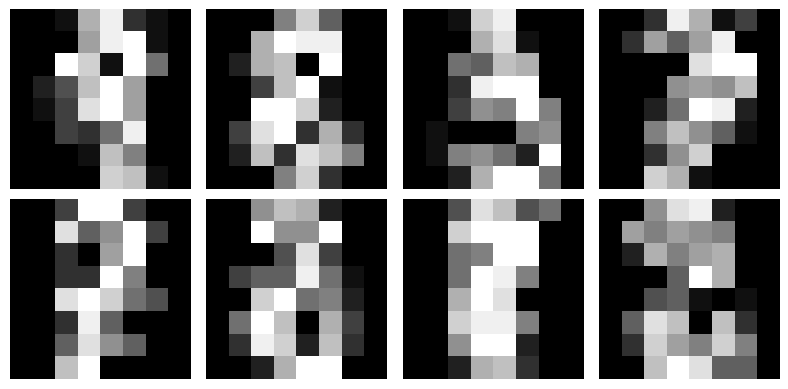

In [141]:
# Draw 8 samples from the saved model
model_best = torch.load(result_dir + name + ".model", weights_only=False)
model_best.eval()
with torch.no_grad():
    samples = model_best.sample(batch_size=8).detach().numpy()
fig, axes = plt.subplots(2, 4, figsize=(8, 4))
for ax, img in zip(axes.flatten(), samples):
    ax.imshow(np.reshape(img, (8, 8)), cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()
